# TOY PROBLEM

The purpose of this notebook is to illustrate the impact that a classifier can have on the world. 

The toy example is as follows:

In a magical land, there's 100 blue haired people and 100 green haired people. Every day, they can eat normal food, or they can steal a cookie from a sacred cookie jar in their house. The initial probabilities of stealing a cookie are $\mu_{blue}=0.6$ for the blues and $\mu_{green}=0.4$ for the greens, as a population. There is also a central fucked up dystopian government, which sends police to the houses of people that it thinks are likely to have stolen a cookie. If the police catches someone stealing a cookie, that person's food is confiscated for the day, and they go hungry (which means that they're likelier to want a cookie the next day, because cookies are more filling than normal food). If not, they progressively lose interest in stealing the cookies, and their probabilities of stealing a cookie diminishes. 

## More formally

Each individual is associated with a feature vector $X$, which is made up of different distributions with mean $\mu$.
At each time step, the means mu are used to generate actual stealing data, i.e. to determine if an individual stole a cookie or not, represented by a vector $y$ full of zeros and ones.
This data is fed into a logistic regression classifier.
Each time step, and for each individual, the classifier predicts whether or not someone will steal a cookie, and depending on that prediction, will decide to send or not send a policeman to their house. If the police is sent to someone's house, and that person gets caught stealing a cookie, that person's $\mu$ increases by $\alpha$. Otherwise, it decreases by $\beta$.

Then I plot each person's $\mu$ over time to see how it evolves!

In [1]:
#import things
import numpy as np
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

#set up hyperparameters
mu_blue = 0.6
mu_green = 0.4
N = 100
alpha = 0.003
beta = 0.003

## This part was mostly initial experimentation.
It can be safely ignored

Generate results vectors for blues and greens

In [2]:
#generate rand uniforms between 0 and 1
y_blue = np.random.uniform(0,1, (N,1))
y_green = np.random.uniform(0,1, (N,1))

#replace each value with 0 or 1
y_blue[y_blue > mu_blue] = 1
y_blue[y_blue <= mu_blue] = 0
y_green[y_green > mu_green] = 1
y_green[y_green <= mu_green] = 0

y_green = np.abs(y_green - 1)
y_blue = np.abs(y_blue - 1)

Which works!

Next, we create 10 dimensional vectors as follows.

Blue_vector =

[drawn from standard normal with mean around mu_B*3 | 
drawn from exponential with mean mu_B + 1 |
drawn from beta with mean mu_B^2 |
standard normal]

The same goes for Green_vector.

In [3]:
#create X_blue
blue_vector1 = np.random.normal(mu_blue*3, 1, (N,3))
blue_vector2 = np.random.exponential(mu_blue + 1, (N,3))
blue_vector3 = np.random.binomial(100, mu_blue**2, (N,3))
blue_vector4 = np.random.standard_normal((N,1))
blue_features = (blue_vector1, blue_vector2, blue_vector3, blue_vector4)

X_blue = np.concatenate(blue_features, axis=1)

#create X_green
green_vector1 = np.random.normal(mu_green*3, 1, (N,3))
green_vector2 = np.random.exponential(mu_green+1, (N,3))
green_vector3 = np.random.binomial(10, mu_green**2, (N,3))
green_vector4 = np.random.standard_normal((N,1))

green_features = (green_vector1, green_vector2, green_vector3, green_vector4)

X_green = np.concatenate(green_features, axis=1)

#append ys
X_blue = np.concatenate((X_blue, y_blue), axis = 1)
X_green = np.concatenate((X_green, y_green), axis = 1)

np.shape(X_green)
np.shape(X_blue)

X = np.concatenate((X_blue, X_green), axis=0)
np.random.shuffle(X)

y = X[:,10]
X = X[:,0:10]

In [4]:
np.shape(X_blue)

(100, 11)

Fit a simple logistic regression model.

In [5]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

#this works, so set up a function:
def fit_logistic_regression(X, y):
    model = LogisticRegression()
    model = model.fit(X, y)
    
    return model
    #return model.coef_, model.intercept_, model.Score(X, y)

model = fit_logistic_regression(X, y)

print(model.score(X, y))

0.59


SO NOW WE HAVE A TRAINED MODEL, WHICH CAN OUTPUT PREDICTIONS.

In [6]:
#this works
predictions = 1 / (1 + np.exp(-(X @ np.transpose(model.coef_) + model.intercept_)))
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

#thus, define a function that does the same thing:
def predict_probs_steal(X, modelcoef, modelintercept):
    predictions = 1 / (1 + np.exp(-(X @ np.transpose(modelcoef) + modelintercept)))
    predictions[predictions > 0.5] = 1
    predictions[predictions <= 0.5] = 0
    
    return predictions

# This is the actual simulation

## Simulation

Now, we're going to have the simulation have an effect on the world in which the Blues and Greens live. 

Suppose that the reason that Blues and Greens is not innate to their complexions, and that ultimately the probability that both Blues and Greens would steal the cookie asymptotes to zero. So each day, $\mu_{blue}$ and $\mu_{green}$ decrease by some amount $\alpha$. We'll start off setting $\alpha = 0.003$.
Then, at each time step, have each person steal a cookie or not steal a cookie (based on their own $\mu_i$, and have the classifier try to predict whether or not each person will steal a cookie. If it predicts that someone steals a cookie, then they go hungry for that day, and their probability of stealing a cookie the next day goes up by $\beta$. We'll start off setting $\beta = 0.003$.

So in order to do that, we're gonna restart everything, individualising each individual.

Set up initial results vectors:

In [7]:
#generate rand uniforms between 0 and 1
y_blue = np.random.uniform(0,1, (N,1))
y_green = np.random.uniform(0,1, (N,1))

#replace each value with 0 or 1
y_blue[y_blue > mu_blue] = 1
y_blue[y_blue <= mu_blue] = 0
y_green[y_green > mu_green] = 1
y_green[y_green <= mu_green] = 0

y_green = np.abs(y_green - 1)
y_blue = np.abs(y_blue - 1)

Create an identity number for each of the 2*N individuals, and also make :

In [8]:
#create identities for each being:
    #give them a number
identities = np.arange(2*N)
identities = np.reshape(identities,(200,1))
    #give them a base rate of stealing the cookies
base_rates_blue = np.ones((N, 1))*mu_blue
base_rates_green = np.ones((N, 1))*mu_green
base_rates = np.concatenate((base_rates_blue, base_rates_green), axis=0)

#create X_blue
thisisatest= np.random.normal(mu_blue*3, 1, (N,3))
blue_vector2 = np.random.exponential(mu_blue + 1, (N,3))
blue_vector3 = np.random.binomial(100, mu_blue**2, (N,3))
blue_vector4 = np.random.standard_normal((N,1))
blue_features = (blue_vector1, blue_vector2, blue_vector3, blue_vector4)

X_blue = np.concatenate(blue_features, axis=1)

#create X_green
green_vector1 = np.random.normal(mu_green*3, 1, (N,3))
green_vector2 = np.random.exponential(mu_green+1, (N,3))
green_vector3 = np.random.binomial(10, mu_green**2, (N,3))
green_vector4 = np.random.standard_normal((N,1))
green_features = (green_vector1, green_vector2, green_vector3, green_vector4)

X_green = np.concatenate(green_features, axis=1)

#append identities, base rates, and mix everything together
X = np.concatenate((X_blue, X_green), axis=0)
X = np.concatenate((X, identities, base_rates), axis=1)
np.random.shuffle(X)


identities = X[:,10]
base_rates = X[:,11]
X = X[:,0:10]

Now we have our first Xs, and we trained our first model. So we can start using the model to make predictions, and use each individual's mu to figure out whether they stole a cookie or not.

## Where all the functions are from

In [9]:
#function to generate actual stealing or not stealing events
def did_they_steal(base_rates):
    
    y = np.zeros((len(base_rates),1))
    
    for i in range(len(base_rates)):
        if base_rates[i] > np.random.uniform(0,1):
            y[i] = 1        
    
    return y

#function to update base rates
def update_base_rates(base_rates, y, predictions, alpha, beta):
    for i in range(len(y)):
        if y[i] == predictions[i] and y[i] == 1 and (base_rates[i] + beta)  < 1:
            base_rates[i] = base_rates[i] + beta
        elif base_rates[i] > alpha:
            base_rates[i] = base_rates[i] - alpha
            
    return base_rates

#function that uses new base rates to create new feature vector
def update_X(base_rates):
    for i in range(len(base_rates)):
        new_vec1 = np.random.normal(base_rates[i]*3, 1, (1, 3))
        new_vec2 = np.random.exponential(base_rates[i]+1, (1, 3))
        new_vec3 = np.random.binomial(100, base_rates[i]**2, (1, 3))
        new_vec4 = np.random.standard_normal((1, 1))
        new_features = (new_vec1, new_vec2, new_vec3, new_vec4)

        X[i] = np.concatenate(new_features, axis=1)
    
    return X

## Running the actual simulation

In [10]:
#generate rand uniforms between 0 and 1
y_blue = np.random.uniform(0,1, (N,1))
y_green = np.random.uniform(0,1, (N,1))

#replace each value with 0 or 1
y_blue[y_blue > mu_blue] = 1
y_blue[y_blue <= mu_blue] = 0
y_green[y_green > mu_green] = 1
y_green[y_green <= mu_green] = 0

y_green = np.abs(y_green - 1)
y_blue = np.abs(y_blue - 1)

#create identities for each being:
    #give them a number
identities = np.arange(2*N)
identities = np.reshape(identities,(200,1))
    #give them a base rate of stealing the cookies
base_rates_blue = np.ones((N, 1))*mu_blue
base_rates_green = np.ones((N, 1))*mu_green
base_rates = np.concatenate((base_rates_blue, base_rates_green), axis=0)

#create X_blue
thisisatest= np.random.normal(mu_blue*3, 1, (N,3))
blue_vector2 = np.random.exponential(mu_blue + 1, (N,3))
blue_vector3 = np.random.binomial(100, mu_blue**2, (N,3))
blue_vector4 = np.random.standard_normal((N,1))
blue_features = (blue_vector1, blue_vector2, blue_vector3, blue_vector4)

X_blue = np.concatenate(blue_features, axis=1)

#create X_green
green_vector1 = np.random.normal(mu_green*3, 1, (N,3))
green_vector2 = np.random.exponential(mu_green+1, (N,3))
green_vector3 = np.random.binomial(10, mu_green**2, (N,3))
green_vector4 = np.random.standard_normal((N,1))
green_features = (green_vector1, green_vector2, green_vector3, green_vector4)

X_green = np.concatenate(green_features, axis=1)

#append identities, base rates, and mix everything together
X = np.concatenate((X_blue, X_green), axis=0)
X = np.concatenate((X, identities, base_rates), axis=1)
np.random.shuffle(X)


identities = X[:,10]
base_rates = X[:,11]
base_rates_copy = np.copy(base_rates)
X = X[:,0:10]

############################STARTS BEING DIFFERENT#######################

iters = 100
base_rates_list = np.zeros((2*N, 1))
score_list = np.zeros((iters, 1))
    
for j in range(iters):
    
    #generate actual stealing or not stealing events, and predictions
    y = did_they_steal(base_rates)
    predictions = predict_probs_steal(X, model.coef_, model.intercept_)

    #update base rates and thus feature vector
    base_rates = update_base_rates(base_rates, y, predictions, alpha, beta)
    X = update_X(base_rates)
    
    base_rates_list= np.concatenate((base_rates_list, np.reshape(base_rates, (200,1))), axis=1)

    #use new feature vector to create new model
    model = fit_logistic_regression(X, np.ravel(y))
    score_list[j] = model.score(X, y)

base_rates_list = base_rates_list[:,1:]


## Plot the results with model based intervention

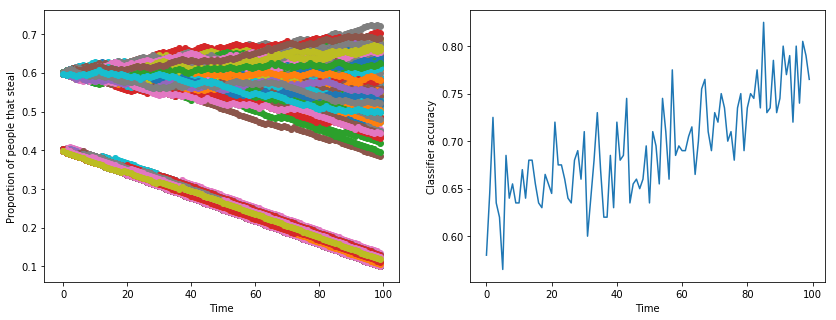

In [11]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
for i in range(2*N):
    plt.scatter(range(iters), base_rates_list[i,:])
plt.xlabel("Time")
plt.ylabel("Proportion of people that steal")
plt.subplot(1, 2, 2)
plt.plot(range(iters), score_list)
plt.xlabel("Time")
plt.ylabel("Classifier accuracy")
plt.savefig("plots/scatter_with_labels_and_score.svg")
plt.show()

# SAD!

The biases get reinforced, and the classifier gets better. Not an ideal world. There are parallels to be drawn with the US justice system :'( 

## Plot the results without model based intervention

In [12]:
#generate rand uniforms between 0 and 1
y_blue = np.random.uniform(0,1, (N,1))
y_green = np.random.uniform(0,1, (N,1))

#replace each value with 0 or 1
y_blue[y_blue > mu_blue] = 1
y_blue[y_blue <= mu_blue] = 0
y_green[y_green > mu_green] = 1
y_green[y_green <= mu_green] = 0

y_green = np.abs(y_green - 1)
y_blue = np.abs(y_blue - 1)

#create identities for each being:
    #give them a number
identities = np.arange(2*N)
identities = np.reshape(identities,(200,1))
    #give them a base rate of stealing the cookies
base_rates_blue = np.ones((N, 1))*mu_blue
base_rates_green = np.ones((N, 1))*mu_green
base_rates = np.concatenate((base_rates_blue, base_rates_green), axis=0)

#create X_blue
blue_vector1 = np.random.normal(mu_blue*3, 1, (N,3))
blue_vector2 = np.random.exponential(mu_blue + 1, (N,3))
blue_vector3 = np.random.binomial(100, mu_blue**2, (N,3))
blue_vector4 = np.random.standard_normal((N,1))
blue_features = (blue_vector1, blue_vector2, blue_vector3, blue_vector4)

X_blue = np.concatenate(blue_features, axis=1)

#create X_green
green_vector1 = np.random.normal(mu_green*3, 1, (N,3))
green_vector2 = np.random.exponential(mu_green+1, (N,3))
green_vector3 = np.random.binomial(10, mu_green**2, (N,3))
green_vector4 = np.random.standard_normal((N,1))
green_features = (green_vector1, green_vector2, green_vector3, green_vector4)

X_green = np.concatenate(green_features, axis=1)

#append identities, base rates, and mix everything together
X = np.concatenate((X_blue, X_green), axis=0)
X = np.concatenate((X, identities, base_rates), axis=1)
np.random.shuffle(X)


identities = X[:,10]
base_rates = X[:,11]
base_rates_copy = np.copy(base_rates)
X = X[:,0:10]

############################STARTS BEING DIFFERENT#######################
iters = 190
base_rates_list_no_intervention = np.zeros((2*N, 1))
score_list2 = np.zeros((iters, 1))

for j in range(iters):
        
    alphaprime = np.random.normal(alpha, 0.003)
    #update base rates
    base_rates_copy[base_rates_copy > alphaprime] = base_rates_copy[base_rates_copy > alphaprime] - alphaprime
    base_rates_list_no_intervention = np.concatenate((base_rates_list_no_intervention, np.reshape(base_rates_copy, (200,1))), axis=1)
    
#     X = update_X(base_rates_copy)
#     y = did_they_steal(base_rates_copy)
    
#     model = fit_logistic_regression(X, np.ravel(y))
#     score_list2[j] = model.score(X, y)

base_rates_list_no_intervention = base_rates_list_no_intervention[:,1:]

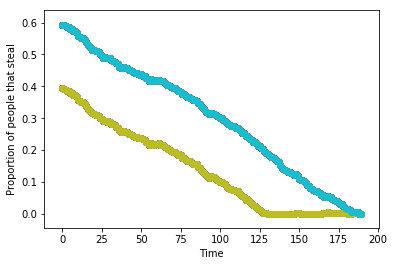

In [13]:
for i in range(2*N):
    plt.scatter(range(iters), base_rates_list_no_intervention[i,:])
plt.xlabel("Time")
plt.ylabel("Proportion of people that steal")
plt.savefig("plots/comparison_to_no_model_effects.svg")
plt.show()